In [9]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [10]:
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
	path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
	print("그림 저장:", fig_id)
	if tight_layout:
		plt.tight_layout()
	plt.savefig(path, format=fig_extension, dpi=resolution)

from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
	rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
	font_name = font_manager.FontProperties(fname=path).get_name()
	rc('font', family=font_name)

In [11]:
mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3

import seaborn as sns
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"
# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# classification
## Minist Data

In [13]:
# 데이터 다운로드
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784',version=1,as_frame=False)
print(mnist.keys())

/Users/kimjimin/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [17]:
X,y=mnist['data'],mnist['target']
print(X.shape)
# 데이터는 784 픽셀을 가진 흑백 이미지, 실제 크기 28*28
# 각 픽셀은 0~255 까지의 값.. 
print(y.shape)

(70000, 784)
(70000,)


(-0.500, 27.500, 27.500, -0.500)

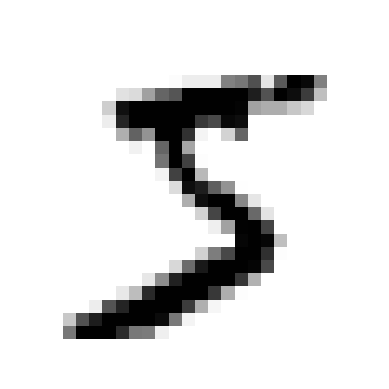

In [19]:
# 하나의 이미지 출력
some_digit=X[0] # 이 이미지는 784 픽셀로 구성. 
some_digit_image=some_digit.reshape(28,28) # 흑백 이미지를 2차원 이미지로 변환
plt.imshow(some_digit_image,cmap=mpl.cm.binary) # 검은색에서 흰색까지의 색상들
plt.axis('off')

In [21]:
# 출력한 이미지의 레이블을 확인
print(y[0])

5


그림 저장: more_digits_plot


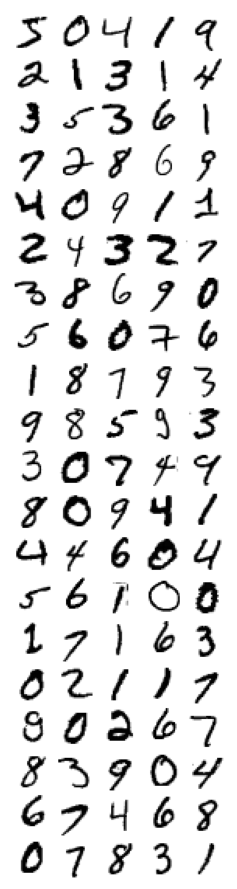

In [22]:
# 여러개의 이미지를 출력하기 위한 함수
# 첫번째 매개변수 - 이미지들, 두번쨰 매개변수 - 하나의 행에 출력할 이미지수( 기본값 10 )
# 세번째 매개변수 - 옵션으로 딕셔너리를 설정. 
# 여러개의 옵션을 설정해야하는 경우 각 매개변수를 나열하는 것은 함수의 가독성을 떨어뜨림.
# 이런 경우 매개변수를 하나로 묶어야 하는데 dict 나 class 가 된다. 
# 생략이 가능한 옵션을 많이 가지고 있다 -> dict, 그렇지 않으면 class 사용.

def plot_digits(instances,images_per_row=10,**options):
    # 이미지 크기 변수로 생성
	size=28
	# 행에 출력할 이미지의 개수
	images_per_row=min(len(instances),images_per_row) # 행에 출력할게 행의 수보다 적으면 그만큼만 출력함
	# 이미지 크기 설정
	images=[instance.reshape(size,size) for instance in instances]
	# 행의 개수 출력
	n_rows=(len(instances)-1)//images_per_row+1 # 몫을 구한다.
	# 이미지 저장할 리스트
	row_images=[]
	n_empty = n_rows * images_per_row - len(instances)
    #0으로 가득채운 행렬을 만들어서 images 에 저장
	images.append(np.zeros((size, size * n_empty)))
    #행 단위로 순회하면서 이미지를 추가
	for row in range(n_rows):
		rimages = images[row * images_per_row : (row + 1) * images_per_row] # 행의 시작 부터 그 다음 행의 전 ( 해당 행의 마지막 데이터까지 의 데이터를 가져옴. )
		row_images.append(np.concatenate(rimages, axis=1))
	image = np.concatenate(row_images, axis=0)
	#이미지 출력
	plt.imshow(image, cmap = mpl.cm.binary, **options)
	plt.axis("off")


plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=5)
plt.show()

In [24]:
# 타겟의 자료형 확인
print(type(y[0]))
# 범주형 데이터의 자료형은 정수를 권장한다.
y=y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


## 이진 분류를 위한 데이터 생성

In [25]:
# 훈련 데이터와 테스트 데이터 분리
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

# 이진 분류의 경우 타겟 값이 2개. 

# 5인지 아닌지 판별하기 위한 데이터. 
y_train_5=(y_train==5)
y_test_5=(y_test==5)
print(y_train_5[0])


True


## sklearn SGDClassifier ( Stochastic Gradient Descent - 확률적 경사 하강법 ) 클래스

### 훈련 및 데이터 예측

In [30]:
from sklearn.linear_model import SGDClassifier

# 훈련에 사용할 모델을 생성 - 하이퍼파라미터 설정
# max_iter는 최대 반복 횟수
# tol은 정밀도
sgd_clf=SGDClassifier(max_iter=1000,tol=1e-3,random_state=42)

# 훈련
sgd_clf.fit(X_train,y_train_5)

# 예측
sgd_clf.predict([some_digit]) # feature 는 2차원 배열 이상이어야 한다., somedigit - 1차원 배열임

array([ True])

### K-fold CrossValidation 을 이용한 accuracy 측정

In [31]:
from sklearn.model_selection import cross_val_score
# 3번 교차 검증 수행하는데 평가 지표는 정확도
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95, 0.96, 0.96])

In [35]:
# 새로운 분류기를 가지고 훈련후 교차 검증 수행. 
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    

never_5_clf=Never5Classifier()
a=cross_val_score(never_5_clf,X_train,y_train,cv=3,scoring='accuracy') # 얘는 왜 y_train_5로 레이블을 지정하지 않은거지?
b=cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy') 
print(a,b)

[0.1   0.097 0.1  ] [0.911 0.909 0.909]


### 분류의 평가지표

#### Confusion Matrix

In [38]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

# 오차행렬 출력
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])